# Lille Metropole Dataset - Qualité de l'air

## 0. Setting-Up

#### Some context

https://fr.wikipedia.org/wiki/Indice_de_qualit%C3%A9_de_l%27air

Le nouvel indice de qualité de l’air ATMO est un indicateur journalier gradué de 1 (bon) à 6 (extrêmement mauvais) qui permet de caractériser de manière simple et globale la qualité de l’air d’une agglomération urbaine.

Il se compose de 5 sous-indices, chacun étant représentatif d'un polluant de l'air :
- dioxyde d'azote (NO2 ou code_no2)
- dioxyde de soufre (SO2 ou code_so2)
- ozone (O3 ou code_o3)
- particules fines de moins de 10mm (PM10 ou code_pm10)
- particules fines de moins de 2.5mm (PM2.5 ou code_pm25)

Le sous-indice le plus élevé détermine l'indice du jour.

Il est calculé à partir des mesures des stations représentatives de la pollution de fond. Il ne prend pas en compte les phénomènes de proximité (automobile ou industriel).

| O3         | SO2       | NO2       | PM10      | PM2.5   | Niveau              |
|------------|-----------|-----------|-----------|---------|---------------------|
| 0 à 50     | 0 à 100   | 0 à 40    | 0 à 20    | 0 à 10  | Bon                 |
| 50 à 100   | 100 à 200 | 40 à 90   | 20 à 40   | 10 à 20 | Moyen               |
| 100 à 130  | 200 à 350 | 90 à 120  | 40 à 50   | 20 à 25 | Dégradé             |
| 130 à 240  | 350 à 500 | 120 à 230 | 50 à 100  | 25 à 50 | Mauvais             |
| 240 à 380  | 500 à 750 | 230 à 340 | 100 à 150 | 50 à 75 | Très mauvais        |
| > 380      | > 750     | > 340     | > 150     | > 75    | Extrêmement mauvais |	 	 	 	 	
 	 	 	 	 	

#### Importing Librairies & Modules

## 1. Collecting the Data

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time # provides various time-related functions
from datetime import datetime
import geopandas as gpd
# from arcgis.features import FeatureLayer

#### Verifying api response

In [18]:
#alternative source: https://data-atmo-hdf.opendata.arcgis.com/search?collection=Dataset
#alternative source: https://services8.arcgis.com/rxZzohbySMKHTNcy/ArcGIS/rest/services/ind_hdf_2021/FeatureServer/0
dataset_id = "indice-qualite-de-lair"
format = "json"
limit = "10"
r = requests.get(f"https://opendata.lillemetropole.fr/api/v2/catalog/datasets/{dataset_id}/exports/{format}?limit={limit}", timeout=2)

print(f"URL: {r.url}")
print(f"HTTP Response Status Code: {r.status_code}") 
print(f"HTTP Error: {r.raise_for_status()}")
print(f"Encoding: {r.encoding}")
print(f"Header content type: {r.headers.get('content-type')}")
print(f"Cookies: {r.cookies}")

r.close()


URL: https://opendata.lillemetropole.fr/api/v2/catalog/datasets/indice-qualite-de-lair/exports/json?limit=10
HTTP Response Status Code: 200
HTTP Error: None
Encoding: utf-8
Header content type: application/json; charset=utf-8
Cookies: <RequestsCookieJar[]>


#### Extracting full dataset into dataframe

In [19]:
dataset_id = "indice-qualite-de-lair"
format = "json"
limit = "-1" # argument to pass to get the full dataset 
df = pd.read_json(f"https://opendata.lillemetropole.fr/api/v2/catalog/datasets/{dataset_id}/exports/{format}?limit={limit}")

df.head()

,date_ech,code_qual,lib_qual,coul_qual,date_dif,source,type_zone,code_zone,lib_zone,code_no2,...,code_pm25,x_wgs84,y_wgs84,x_reg,y_reg,epsg_reg,objectid,geo_shape,geo_point_2d,code_posta
0,2022-05-05T02:00:00+00:00,2,Moyen,#50CCAA,2022-05-06T14:10:06+00:00,Atmo HDF,commune,59051,BASSEE,1,...,2,2.80943,50.54002,686469,7049214,2154,460317,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.80943, 'lat': 50.54001999999999}",59480
1,2022-05-05T02:00:00+00:00,2,Moyen,#50CCAA,2022-05-06T14:10:06+00:00,Atmo HDF,commune,59056,BEAUCAMPS LIGNY,1,...,2,2.91439,50.60625,693929,7056581,2154,460322,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.914389999999999, 'lat': 50.606249999...",59134
2,2022-05-05T02:00:00+00:00,2,Moyen,#50CCAA,2022-05-06T14:10:06+00:00,Atmo HDF,commune,59106,BOUVINES,1,...,2,3.19263,50.58194,713665,7053885,2154,460371,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 3.19263, 'lat': 50.58194000000001}",59830
3,2022-05-05T02:00:00+00:00,2,Moyen,#50CCAA,2022-05-06T14:10:06+00:00,Atmo HDF,commune,59146,CHERENG,1,...,2,3.20959,50.61086,714860,7057111,2154,460411,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 3.20959, 'lat': 50.610859999999995}",59152
4,2022-05-05T02:00:00+00:00,2,Moyen,#50CCAA,2022-05-06T14:10:06+00:00,Atmo HDF,commune,59201,ERQUINGHEM LE SEC,1,...,2,2.93325,50.61081,695267,7057087,2154,460465,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.93325, 'lat': 50.61081}",59320


In [20]:
df.tail()

,date_ech,code_qual,lib_qual,coul_qual,date_dif,source,type_zone,code_zone,lib_zone,code_no2,...,code_pm25,x_wgs84,y_wgs84,x_reg,y_reg,epsg_reg,objectid,geo_shape,geo_point_2d,code_posta
25930,2022-09-30T02:00:00+00:00,2,Moyen,#50CCAA,2022-10-01T14:10:07+00:00,Atmo HDF,commune,59044,BAISIEUX,2,...,1,3.24137,50.61093,717113,7057125,2154,1017293,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 3.24137, 'lat': 50.610929999999996}",59780
25931,2022-09-30T02:00:00+00:00,2,Moyen,#50CCAA,2022-10-01T14:10:07+00:00,Atmo HDF,commune,59128,CAPINGHEM,2,...,1,2.96453,50.64707,697487,7061127,2154,1017376,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.96453, 'lat': 50.64706999999999}",59160
25932,2022-09-30T02:00:00+00:00,2,Moyen,#50CCAA,2022-10-01T14:10:07+00:00,Atmo HDF,commune,59250,FOURNES EN WEPPES,1,...,1,2.89312,50.59193,692419,7054987,2154,1017494,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.89312, 'lat': 50.59192999999999}",59134
25933,2022-09-30T02:00:00+00:00,2,Moyen,#50CCAA,2022-10-01T14:10:07+00:00,Atmo HDF,commune,59252,FRELINGHIEN,1,...,1,2.95157,50.70296,696572,7067356,2154,1017496,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.9515700000000002, 'lat': 50.70296}",59236
25934,2022-09-30T02:00:00+00:00,2,Moyen,#50CCAA,2022-10-01T14:10:07+00:00,Atmo HDF,commune,59278,HALLENNES LEZ HAUBOURDIN,1,...,1,2.95469,50.61192,696787,7057210,2154,1017522,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': 2.9546900000000003, 'lat': 50.61192}",59320


#### Exporting raw data to CSV

In [21]:
# generating a raw csv file with timestamp including in the name
timestr = time.strftime("%Y%m%d-%H%M%S")
file_name = "indice-qualite-de-lair_" + timestr + ".csv"
print(f"file name: {file_name}")

df.to_csv('da_data_raw\\' + file_name, index = False)

file name: indice-qualite-de-lair_20221004-152308.csv


## 2. Preparing Data for Analysis

#### First basic information about the DataFrame

In [22]:
# data.info has the merits of combining many functions together
# - see if there's null values replacing `df.isnull().sum()`
# - see the dtype of each colymns replacing `df.dtypes`
# - see the shape of the dataframe replacing `df.shape`
# - estimating the memory usage replacing `df.memory_usage`
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25935 entries, 0 to 25934
Data columns (total 23 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date_ech      25935 non-null  object 
 1   code_qual     25935 non-null  int64  
 2   lib_qual      25935 non-null  object 
 3   coul_qual     25935 non-null  object 
 4   date_dif      25935 non-null  object 
 5   source        25935 non-null  object 
 6   type_zone     25935 non-null  object 
 7   code_zone     25935 non-null  int64  
 8   lib_zone      25935 non-null  object 
 9   code_no2      25935 non-null  int64  
 10  code_so2      25935 non-null  int64  
 11  code_o3       25935 non-null  int64  
 12  code_pm10     25935 non-null  int64  
 13  code_pm25     25935 non-null  int64  
 14  x_wgs84       25935 non-null  float64
 15  y_wgs84       25935 non-null  float64
 16  x_reg         25935 non-null  int64  
 17  y_reg         25935 non-null  int64  
 18  epsg_reg      25935 non-nu

One issue observed is the number of "object" dtypes knowing that we would be able to leverage more functions if some of them were more specifics (string, date...). 

In [23]:
# quick overview of date_ech
df["date_ech"].value_counts(ascending=True)

2022-05-05T02:00:00+00:00    95
2022-01-14T01:00:00+00:00    95
2022-01-15T01:00:00+00:00    95
2022-01-16T01:00:00+00:00    95
2022-01-17T01:00:00+00:00    95
                             ..
2022-06-19T02:00:00+00:00    95
2022-06-17T02:00:00+00:00    95
2022-06-16T02:00:00+00:00    95
2022-06-23T02:00:00+00:00    95
2022-09-29T02:00:00+00:00    95
Name: date_ech, Length: 273, dtype: int64

In [24]:
# quick overview of date_dif
df["date_dif"].value_counts(ascending=True)

2022-05-06T14:10:06+00:00     95
2022-01-14T14:10:07+00:00     95
2022-01-15T14:10:07+00:00     95
2022-01-16T14:10:06+00:00     95
2022-01-17T14:10:07+00:00     95
                            ... 
2022-06-18T14:10:07+00:00     95
2022-06-17T14:10:07+00:00     95
2022-06-23T14:10:07+00:00     95
2022-09-30T14:10:07+00:00     95
2022-10-03T14:10:07+00:00    285
Name: date_dif, Length: 271, dtype: int64

In [26]:
df["lib_zone"].nunique()

95

We have 95 observations each day (i.e. 95 cities **lib_zone**) but we sometimes have 190 unique dates which is suspicious and look like duplicates. 
Note that it doesn't happen at each import and therefore the code related to the removal of duplicates isn't always necessary (but doesn't hurt).

#### Dealing with potential duplicates

Performing a `df.duplicated().sum()` gives me a *TypeError: unhashable type: 'dict'* error. This is because columns **geo_shape** and **geo_point_2d** are dictionaries. I'll exclude them. 

In [27]:
# check duplication of df excluding geo_shape and geo_point_2d
df.duplicated(df.columns.difference(['geo_shape', 'geo_point_2d'])).sum()

0

I found this **0** result to be strange given my initial observations with dates **value_counts** and decided to proceed further by including columns one by one to see if duplicates emerge

In [28]:
df.duplicated(['date_ech', 'date_dif', 'code_zone', 'lib_zone', 'code_qual', 'lib_qual', 'coul_qual', 'source', 'type_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10', 'code_pm25', 'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg']).sum()

0

In [29]:
df.duplicated(['date_ech', 'date_dif', 'code_zone', 'lib_zone', 'code_qual', 'lib_qual', 'coul_qual', 'source', 'type_zone', 'code_no2', 'code_so2', 'code_o3', 'code_pm10', 'code_pm25', 'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg', 'objectid']).sum()

0

The only difference between the two lines of code above is the presence of **objectid** in the second one. In other words, there are numerous duplicates if we ignore **objectid**. Since all other variables are similar and we expect one observation per day per city, I will remove **objectid**, then remove duplicates. 

In [30]:
# removeing objectid column
df.drop(columns=['objectid'], inplace=True)

# converting **geo_shape** and **geo_point_2d** to string
df['geo_shape'] = df.geo_shape.astype(str)
df['geo_point_2d'] = df.geo_point_2d.astype(str)

In [31]:
df.duplicated().sum()

0

In [32]:
df.drop_duplicates(inplace=True)

In [33]:
df["date_ech"].value_counts(ascending=True)

2022-05-05T02:00:00+00:00    95
2022-01-14T01:00:00+00:00    95
2022-01-15T01:00:00+00:00    95
2022-01-16T01:00:00+00:00    95
2022-01-17T01:00:00+00:00    95
                             ..
2022-06-19T02:00:00+00:00    95
2022-06-17T02:00:00+00:00    95
2022-06-16T02:00:00+00:00    95
2022-06-23T02:00:00+00:00    95
2022-09-29T02:00:00+00:00    95
Name: date_ech, Length: 273, dtype: int64

In [34]:
df["date_dif"].value_counts(ascending=True)

2022-05-06T14:10:06+00:00     95
2022-01-14T14:10:07+00:00     95
2022-01-15T14:10:07+00:00     95
2022-01-16T14:10:06+00:00     95
2022-01-17T14:10:07+00:00     95
                            ... 
2022-06-18T14:10:07+00:00     95
2022-06-17T14:10:07+00:00     95
2022-06-23T14:10:07+00:00     95
2022-09-30T14:10:07+00:00     95
2022-10-03T14:10:07+00:00    285
Name: date_dif, Length: 271, dtype: int64

#### Removal & Renaming of columns

In [37]:
subset = df.drop(columns=['coul_qual', 'date_dif', 'source', 'type_zone', 'code_zone', 'x_wgs84', 'y_wgs84', 'x_reg', 'y_reg', 'epsg_reg', 'geo_shape', 'geo_point_2d'], errors='ignore')

In [38]:
subset.head()

,date_ech,code_qual,lib_qual,lib_zone,code_no2,code_so2,code_o3,code_pm10,code_pm25,code_posta
0,2022-05-05T02:00:00+00:00,2,Moyen,BASSEE,1,1,2,1,2,59480
1,2022-05-05T02:00:00+00:00,2,Moyen,BEAUCAMPS LIGNY,1,1,2,1,2,59134
2,2022-05-05T02:00:00+00:00,2,Moyen,BOUVINES,1,1,2,1,2,59830
3,2022-05-05T02:00:00+00:00,2,Moyen,CHERENG,1,1,2,1,2,59152
4,2022-05-05T02:00:00+00:00,2,Moyen,ERQUINGHEM LE SEC,1,1,2,1,2,59320


In [42]:
code_posta = subset.pop('code_posta')
subset.insert(3, 'code_posta', code_posta)

subset.head()

,date_ech,code_qual,lib_qual,code_posta,lib_zone,code_no2,code_so2,code_o3,code_pm10,code_pm25
0,2022-05-05T02:00:00+00:00,2,Moyen,59480,BASSEE,1,1,2,1,2
1,2022-05-05T02:00:00+00:00,2,Moyen,59134,BEAUCAMPS LIGNY,1,1,2,1,2
2,2022-05-05T02:00:00+00:00,2,Moyen,59830,BOUVINES,1,1,2,1,2
3,2022-05-05T02:00:00+00:00,2,Moyen,59152,CHERENG,1,1,2,1,2
4,2022-05-05T02:00:00+00:00,2,Moyen,59320,ERQUINGHEM LE SEC,1,1,2,1,2


In [43]:
cols = ['date', 'quality_code', 'quality_label', 'zip_code', 'city', 'no2', 'so2', 'o3', 'pm10', 'pm2-5']
subset.columns = cols

subset.head()

,date,quality_code,quality_label,zip_code,city,no2,so2,o3,pm10,pm2-5
0,2022-05-05T02:00:00+00:00,2,Moyen,59480,BASSEE,1,1,2,1,2
1,2022-05-05T02:00:00+00:00,2,Moyen,59134,BEAUCAMPS LIGNY,1,1,2,1,2
2,2022-05-05T02:00:00+00:00,2,Moyen,59830,BOUVINES,1,1,2,1,2
3,2022-05-05T02:00:00+00:00,2,Moyen,59152,CHERENG,1,1,2,1,2
4,2022-05-05T02:00:00+00:00,2,Moyen,59320,ERQUINGHEM LE SEC,1,1,2,1,2


#### Converting Dates

In [ ]:
subset.dtypes

In [48]:
#convert date
subset["date"] = pd.to_datetime(subset["date"]).dt.normalize()
subset.head()

,date,quality_code,quality_label,zip_code,city,no2,so2,o3,pm10,pm2-5
0,2022-05-05,2,Moyen,59480,BASSEE,1,1,2,1,2
1,2022-05-05,2,Moyen,59134,BEAUCAMPS LIGNY,1,1,2,1,2
2,2022-05-05,2,Moyen,59830,BOUVINES,1,1,2,1,2
3,2022-05-05,2,Moyen,59152,CHERENG,1,1,2,1,2
4,2022-05-05,2,Moyen,59320,ERQUINGHEM LE SEC,1,1,2,1,2


In [51]:
subset.dtypes

date             datetime64[ns]
quality_code              int64
quality_label            object
zip_code                  int64
city                     object
no2                       int64
so2                       int64
o3                        int64
pm10                      int64
pm2-5                     int64
dtype: object

In [54]:
subset.sort_values(by='date')

,date,quality_code,quality_label,zip_code,city,no2,so2,o3,pm10,pm2-5
11187,2022-01-01,2,Moyen,59496,SALOME,1,1,2,2,2
11177,2022-01-01,2,Moyen,59510,FOREST SUR MARQUE,2,1,2,2,2
11176,2022-01-01,2,Moyen,59155,FACHES THUMESNIL,2,1,2,2,2
11175,2022-01-01,2,Moyen,59320,EMMERIN,1,1,2,2,2
11174,2022-01-01,2,Moyen,59560,COMINES,1,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...
7240,2022-10-04,2,Moyen,59134,HERLIES,1,1,2,1,2
7236,2022-10-04,2,Moyen,59250,HALLUIN,1,1,2,1,2
7234,2022-10-04,2,Moyen,59320,HALLENNES LEZ HAUBOURDIN,1,1,2,1,2
23961,2022-10-04,2,Moyen,59780,BAISIEUX,1,1,2,1,2


#### Exporting subset to CSV

In [56]:
# generating a subset csv file with timestamp including in the name
timestr = time.strftime("%Y%m%d-%H%M%S")
file_name = "indice-qualite-de-lair_" + timestr + ".csv"
print(f"file name: {file_name}")

subset.to_csv('da_data_workfiles\\' + file_name, index = False)

file name: indice-qualite-de-lair_20221004-160623.csv


## 3. Data Analysis & Visualization

<AxesSubplot: xlabel='date', ylabel='quality_code'>

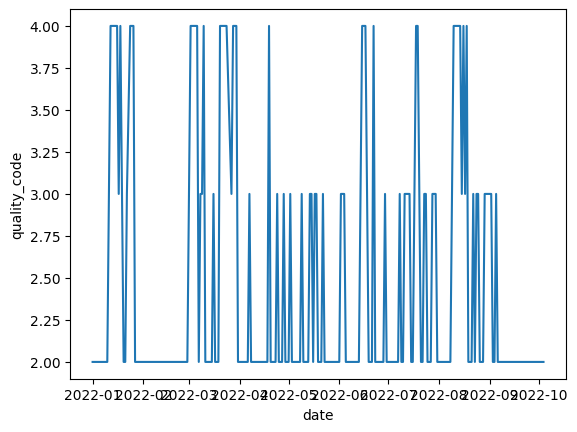

In [59]:
#retriving day and code_qual data filtered only for rows with "LILLE"
dates_lille = subset[subset['city'] == "LILLE"]['date']
qual_lille = subset[subset['city'] == "LILLE"]['quality_code']
df_qual_lille = { 'date': dates_lille, 'quality_code': qual_lille }

#plot 
sns.lineplot(data=df_qual_lille, x='date', y='quality_code')